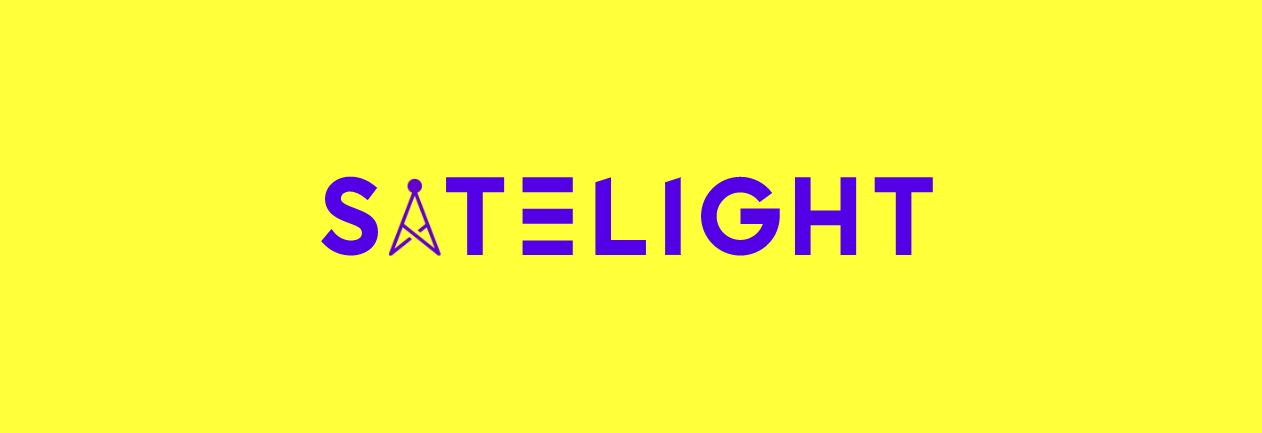

# Introduction
SateLight does the task of image retrieval. It uses a simple architecture trained on the <a href="https://www.kaggle.com/datasets/crawford/deepsat-sat6" target="_blank">DeepSat (SAT-6) dataset</a>, with the triplet loss function.

# Dataset
Originally, images were extracted from the National Agriculture Imagery Program (NAIP) dataset. The NAIP dataset consists of a total of 330,000 scenes spanning the whole of the Continental United States (CONUS). 

Once labeled, 28x28 non-overlapping sliding window blocks were extracted from the uniform image patch and saved to the dataset with the corresponding label. 

The images consist of 4 bands - red, green, blue and Near Infrared (NIR). In order to maintain the high variance inherent in the entire NAIP dataset, we sample image patches from a multitude of scenes (a total of 1500 image tiles) covering different landscapes like rural areas, urban areas, densely forested, mountainous terrain, small to large water bodies, agricultural areas, etc.

## Download
Let's download the dataset and extract it. If you're not running the notebook on colab, try downloading the dataset from <a href="https://www.kaggle.com/datasets/crawford/deepsat-sat6">here</a>, and unzip it yourself. 

In [1]:
!gdown '1--4Iq9-EaBEFY-Wh_maYIG9YQtmonjkJ&confirm=t'
!unzip dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1--4Iq9-EaBEFY-Wh_maYIG9YQtmonjkJ&confirm=t
To: /content/dataset.zip
100% 2.60G/2.60G [00:12<00:00, 201MB/s]
Archive:  dataset.zip
  inflating: X_test_sat6.csv         
  inflating: X_train_sat6.csv        
  inflating: sat-6-full.mat          
  inflating: sat6annotations.csv     
  inflating: y_test_sat6.csv         
  inflating: y_train_sat6.csv        


## Read and store the data
We'll use the `pandas` library to read the `.csv` files.

In [2]:
import pandas as pd

In [3]:
x_train_df = pd.read_csv('X_train_sat6.csv', dtype='uint8', nrows=32400)
x_val_df = pd.read_csv('X_test_sat6.csv', dtype='uint8', nrows=8100)
y_train_df = pd.read_csv('y_train_sat6.csv', dtype='uint8', nrows=32400)
y_val_df = pd.read_csv('y_test_sat6.csv', dtype='uint8', nrows=8100)

Each row in the *x* dataframes contain pixel values of the flattened 28x28x4 images. Each row in the *y* dataframes contain the one-hot encoded class of the corresponding image. We need to reshape the *x* dataframes and convert the one-hot encoded classes in *y* dataframes to normal integer indices.

In [6]:
import numpy as np

In [7]:
x_train = x_train_df.values.reshape((-1, 28, 28, 4))
x_val = x_val_df.values.reshape((-1, 28, 28, 4))
one_hot_to_int = lambda x: np.where(x == 1)[0][0]
y_train = y_train_df.apply(one_hot_to_int, axis=1).values.ravel().astype('uint8')
y_val = y_val_df.apply(one_hot_to_int, axis=1).values.ravel().astype('uint8')
del x_train_df, y_train_df, x_val_df, y_val_df

## Inspect the dataset
Our six classes are as follows:

In [8]:
CLASSES = ['Buildings', 'Barren Land', 'Trees', 'Grassland', 'Roads', 'Water Bodies']

With the corresponding labels which are present in our *y* datasets' labels.

In [9]:
CLASS_INDICES = [0, 1, 2, 3, 4, 5]

And here, are the indices of our training samples, which we'll require later.

In [10]:
TRAIN_INDICES = np.array(list(range(len(y_train))))
print(TRAIN_INDICES)

[    0     1     2 ... 32397 32398 32399]


Let's see the shape of our datasets.

In [11]:
print('X_train shape: ', x_train.shape, 'Y_train shape: ', y_train.shape)
print('X_val shape: ', x_val.shape, 'Y_val shape: ', y_val.shape)

X_train shape:  (32400, 28, 28, 4) Y_train shape:  (32400,)
X_val shape:  (8100, 28, 28, 4) Y_val shape:  (8100,)


Let's see some of the samples in the training dataset. We'll not plot the last alpha channel of the images for better visualization.

In [12]:
import matplotlib.pyplot as plt

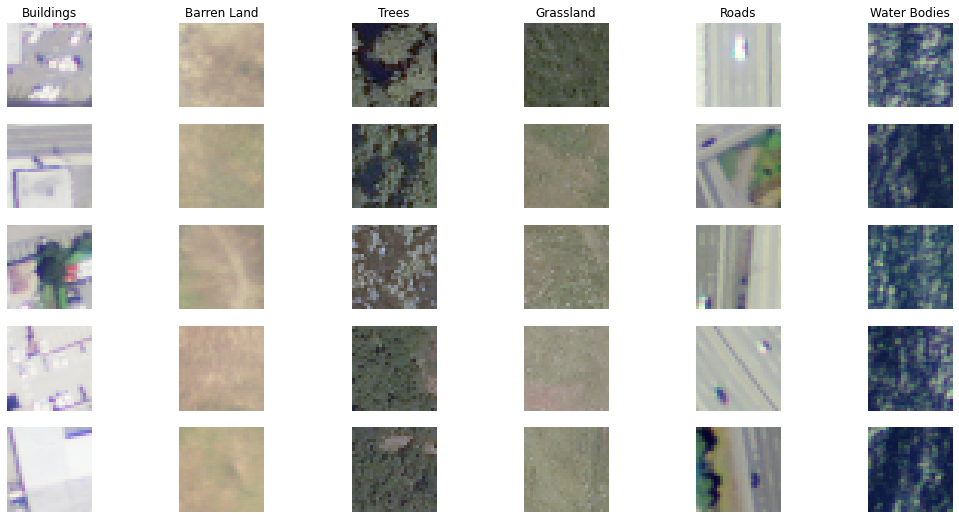

In [13]:
fig, axes = plt.subplots(figsize=(18, 9), nrows=5, ncols=6)
indices = []
for i in range(6):
    axes[0, i].set_title(CLASSES[i])
    indices.append(np.random.choice(TRAIN_INDICES[y_train==i], 5, replace=False))
for i in range(5):
    for j in range(6):
        axes[i, j].axis('off')
        axes[i, j].imshow(x_train[indices[j][i]][:, :, :3])
plt.show()

You can run the cell above multiple times to see different samples.

# Model
The architecture used is a simple convnet with an FC (Fully Connected) layer at the end for feature representation, i.e., creating the embeddings.

In [14]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model

## Metric model
Here is the core of our model. Later, we'll accompany this with workarounds to customize it for our specific task of triplet training.

In [15]:
metric_model = Sequential([
    tfl.Lambda(lambda image: tf.cast(image, dtype=tf.float32) / 255., name='Normalizer'), # Normalize the pixel values
    tfl.Conv2D(filters=8, kernel_size=(2, 2), padding='same', name='Conv_1'),
    tfl.BatchNormalization(name='BatchNorm_1'),
    tfl.ReLU(name='ReLU_1'),
    tfl.MaxPooling2D(name='MaxPool_1'),
    tfl.Conv2D(filters=16, kernel_size=(2, 2), padding='same', name='Conv_2'),
    tfl.BatchNormalization(name='BatchNorm_2'),
    tfl.ReLU(name='ReLU_2'),
    tfl.MaxPooling2D(name='MaxPool_2'),
    tfl.Flatten(name='Flatten'),
    tfl.Dense(16, name='Features')
], name='MetricModel')

Let's visualize it.

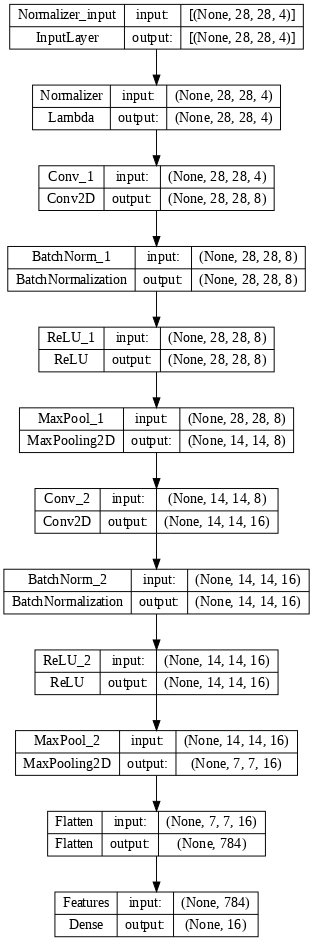

In [16]:
metric_model_input_shape = (None, *x_train.shape[1:])
metric_model.build(metric_model_input_shape)
tf.keras.utils.plot_model(metric_model, dpi=70, expand_nested=True, show_shapes=True)

## Main model
Our model needs to be trained on triplets of samples, meaning in each forward pass during training, it needs to take in 3 samples. Thus, we need something like a wrapper.

In [17]:
a_inp = tfl.Input(shape=(28, 28, 4), name='anchor')
p_inp = tfl.Input(shape=(28, 28, 4), name='positive')
n_inp = tfl.Input(shape=(28, 28, 4), name='negative')

out = tfl.Lambda(lambda x: K.stack(x, axis=1), name='embeddings')([
    metric_model(a_inp),
    metric_model(p_inp),
    metric_model(n_inp)
])

model = Model(inputs=[a_inp, p_inp, n_inp], outputs=out)

Let's visualize this as well.

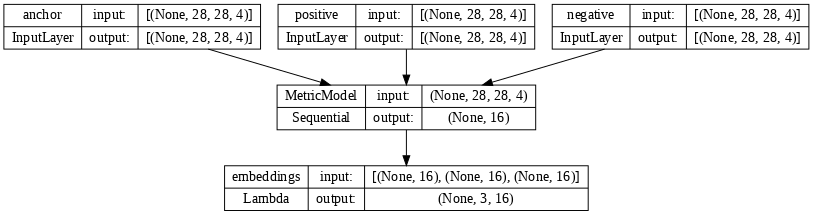

In [18]:
tf.keras.utils.plot_model(model, dpi=70, expand_nested=False, show_shapes=True)

# Loss
We'll use the triplet loss function, first introduced in <a href="https://arxiv.org/abs/1503.03832" target="_blank">*FaceNet: A Unified Embedding for Face Recognition and Clustering*</a>. We need to train the model, such that the predicted embeddings of samples in the same class are as similar as possible, and as different as possible from the samples in other classes.

In each forward pass, we'll have 3 images, an anchor, a positive, and a negative. Anchor and positive are from the same class, whereas the negative image is from a different class.

The goal is to create 3 embeddings, where anchor's and positive's are closely similar and far different from negative's. In other words, the distance, here, the L2 distance, from anchor's embedding to positive's has to be lower than anchor's to negative's.

This is the triplet loss formula, for a batch of $m$ input samples, where $a$, $p$, and $n$ denote the anchor, positive, and negative samples, respectively, and $\alpha$ is known as margin, to prevent the model from predicting symmetric embeddings:
$$
max(\sum^{m}_{i=1}[\left | f^a_i - f^p_i \right |^{2}_{2} - \left | f^a_i - f^n_i \right |^{2}_{2} + \alpha], 0)
$$

Not getting too much into the details, by optimizing the function above w.r.t. our model's parameters, we'll be able to create embeddings that represent our classes correctly.

In [19]:
def triplet_loss(_, y_pred, batch_size=32, margin=2):
  a, p, n = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
  d_a_p = K.sum(K.square(a - p), axis=-1)
  d_a_n = K.sum(K.square(a - n), axis=-1)
  loss = K.sum(K.relu(d_a_p - d_a_n + margin))
  return loss / batch_size

As can be seen, the result has been divided by batch size to make it independent of the size of inputs.

# Batch generator
Our generator will create random triples `(a, p, n)` where `a` and `p` are from the same class and `n` is from a different one.

In [20]:
def get_triplet_batch(x, y, indices, batch_size=32, classes=CLASS_INDICES):
    a = []
    p = []
    n = []
    while True:
        for _ in range(batch_size):
            positive_class, negative_class = np.random.choice(classes, 2, replace=False)
            anchor_image_index, positive_image_index = np.random.choice(indices[y==positive_class], 2, replace=False)
            negative_image_index = np.random.choice(indices[y==negative_class])
            a.append(x[anchor_image_index])
            p.append(x[positive_image_index])
            n.append(x[negative_image_index])
        yield([np.array(a), np.array(p), np.array(n)], np.zeros(shape=(batch_size,)))

Let's see how the batches are going to be created. We'll not plot the last alpha channel of the images for better visualization.

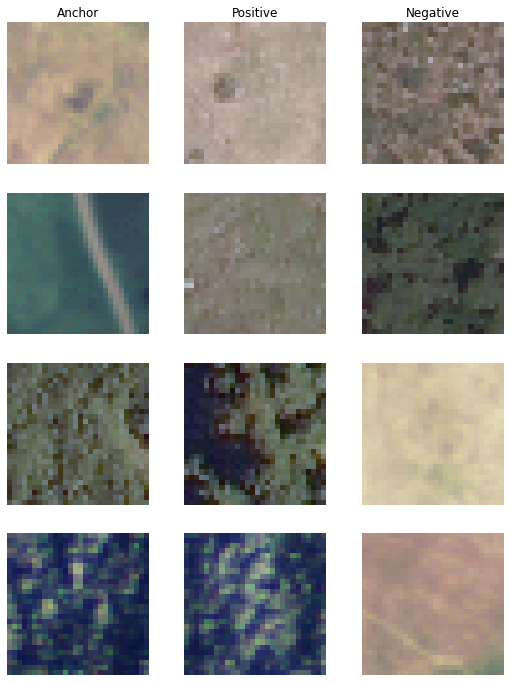

In [21]:
batch, _ = next(get_triplet_batch(x_train, y_train, TRAIN_INDICES, batch_size=4))
fig, axes = plt.subplots(figsize=(9, 12), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i, j].axis('off')
        axes[i, j].imshow(batch[j][i][:, :, :3])
titles = ['Anchor', 'Positive', 'Negative']
for i in range(3):
    axes[0, i].set_title(titles[i])

# Training
We'll train the model with 100 steps per epoch, with a batch size of 32, covering 32x3x100 images. Training for 10 epochs seems sufficient.

In order to fit the model, we need to compile it with our loss function, and optionally the *Adam* optimizer.

In [20]:
optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss=triplet_loss, optimizer=optimizer)

In [116]:
model.fit(
    get_triplet_batch(x_train, y_train, TRAIN_INDICES),
    steps_per_epoch=100,
    epochs=10
)


Epoch 1/10
100/100 [==============================] - 18s 170ms/step - loss: 1.2208
Epoch 2/10
100/100 [==============================] - 51s 514ms/step - loss: 0.9881
Epoch 3/10
100/100 [==============================] - 84s 843ms/step - loss: 1.0797
Epoch 4/10
100/100 [==============================] - 118s 1s/step - loss: 0.8783
Epoch 5/10
100/100 [==============================] - 152s 2s/step - loss: 0.4594
Epoch 6/10
100/100 [==============================] - 186s 2s/step - loss: 0.8839
Epoch 7/10
100/100 [==============================] - 250s 3s/step - loss: 1.0177
Epoch 8/10
100/100 [==============================] - 327s 3s/step - loss: 0.8114
Epoch 9/10
100/100 [==============================] - 367s 4s/step - loss: 0.8665
Epoch 10/10
100/100 [==============================] - 407s 4s/step - loss: 0.4994



# Inspection
For this part, we can either use the model we just trained, or a pre-trained model with the same configuration. Run the cell below if you didn't finish the training.

In [22]:
!wget -q 'https://raw.githubusercontent.com/rezmansouri/SateLight/main/model.h5'
model = tf.keras.models.load_model('model.h5', custom_objects={'triplet_loss': triplet_loss})

Let's see how the model is performing on training triplets.

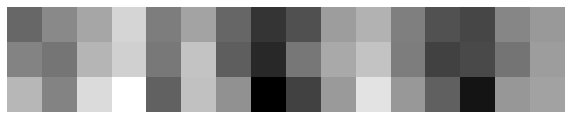

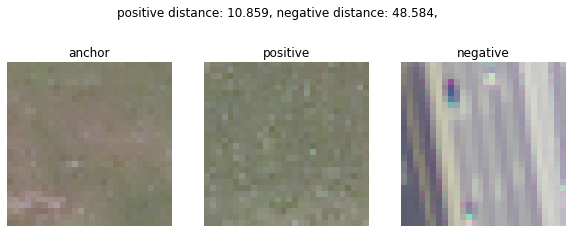

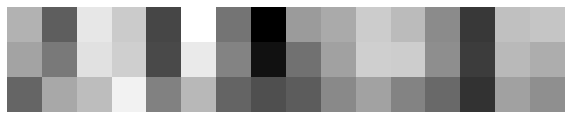

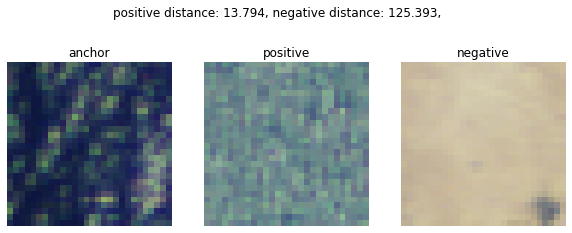

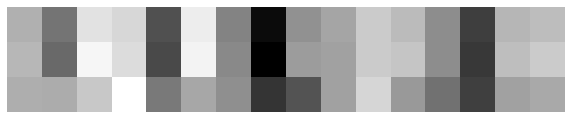

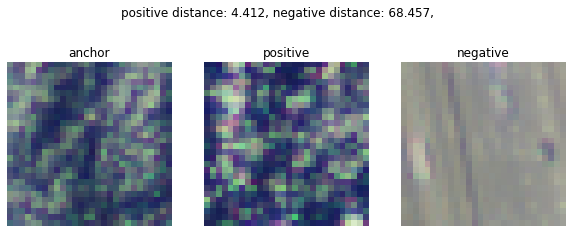

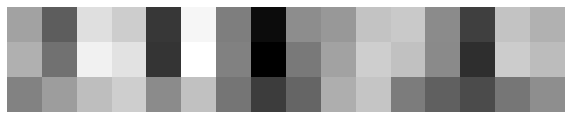

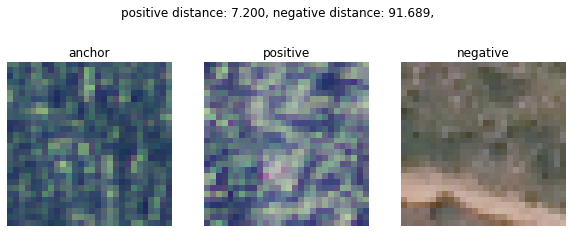

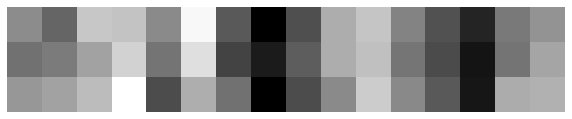

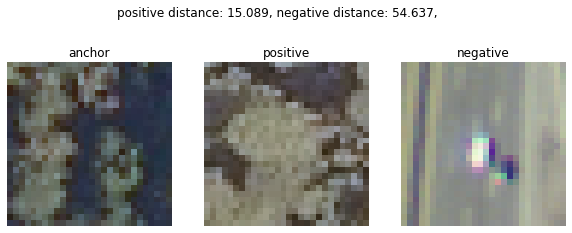

In [23]:
batch, _ = next(get_triplet_batch(x_train, y_train, TRAIN_INDICES, batch_size=5))
preds = model(batch)

for i in range(5):
    a_embs, p_embs, n_embs = preds[i]
    fig, axs = plt.subplots(num=i, figsize=(10, 3.5))
    axs.set_axis_off()
    axs.matshow(preds[i], cmap='gray')
    d_a_p = np.sum(np.square(a_embs - p_embs), axis=-1)
    d_a_n = np.sum(np.square(a_embs - n_embs), axis=-1)
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'positive distance: {d_a_p:.3f}, negative distance: {d_a_n:.3f},')
    plt.subplot(1, 3, 1, title='anchor').axis('off')
    plt.imshow(batch[0][i][:, :, :3])
    plt.subplot(1, 3, 2, title='positive').axis('off')
    plt.imshow(batch[1][i][:, :, :3])
    plt.subplot(1, 3, 3, title='negative').axis('off')
    plt.imshow(batch[2][i][:, :, :3])
    plt.show()
    print('\n')

As can be seen, the embeddings of the anchor and positive samples look more similar than to the anchor and negative samples, leading to bigger distance between anchor and negative than anchor and positive. Our model was trained adequately.

Now, instead of giving the model triplets, we want it to predict embeddings for single instances, and then we can compare it to other instances' embeddings to obtain top-*k* similar ones.

## Prediction model
Our architechture, specifically, the wrapper we created for triplet training, needs to be modified, so that it can process single instances, instead of triplets.

In [24]:
metric_model = model.layers[3]
input = tfl.Input(shape=(28, 28, 4), name='input')
output = metric_model(input)
prediction_model = Model(inputs=input, outputs=output)

Let's visualize it so we can be sure we're doing it right.

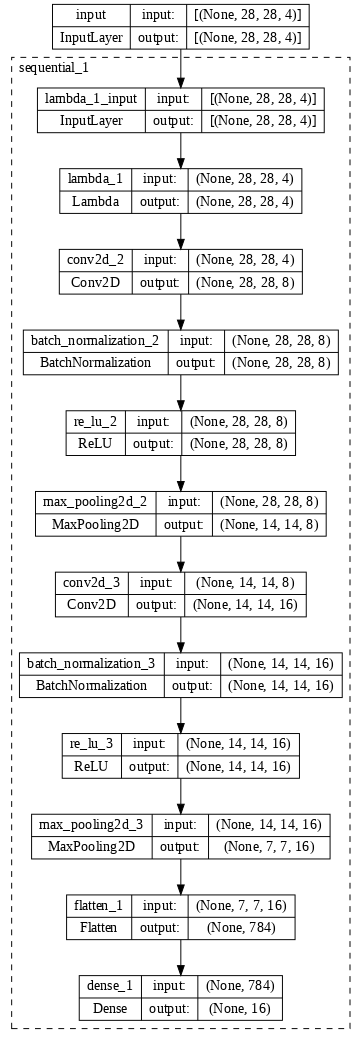

In [25]:
tf.keras.utils.plot_model(prediction_model, dpi=70, expand_nested=True, show_shapes=True)

## Obtain training embeddings
We want to predict the embeddings of all our training samples, so that we can explore them in order to see the model's performance.

In [26]:
train_embeddings = prediction_model.predict(x_train)

1013/1013 [==============================] - 7s 7ms/step


## Similarity matrix
Let's compute the distances between the embeddings of our validation samples, which results in a matrix. We'll use scikit-learn's pairwise implementation of L2 distance here. 

In [27]:
from sklearn.metrics.pairwise import euclidean_distances
train_similarities = euclidean_distances(train_embeddings)
del train_embeddings

Plotting the matrix, the darker each cell, the lower the distance, i.e., the higher the similarity:

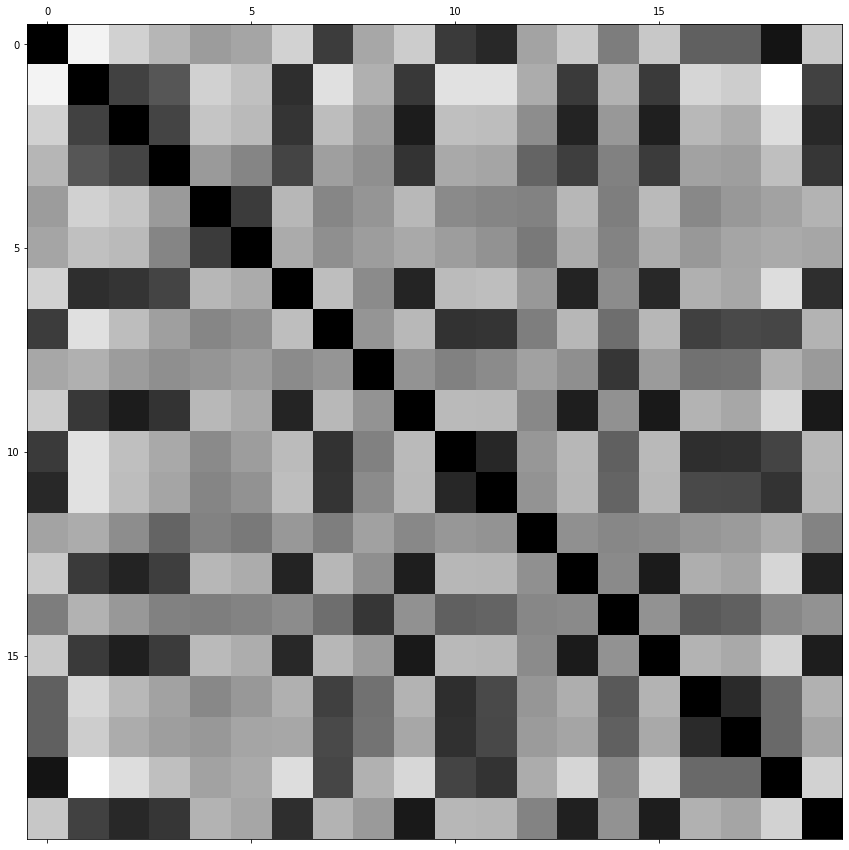

In [28]:
plt.figure(figsize=(15, 15), num=0)
plt.matshow(train_similarities[:20, :20], cmap='gray', fignum=0)

## Top-*k* accuracy

The following functions will find the top-*k* candidates for a query image.

In [29]:
def show_image(ax, image, query_class_index, class_index=None, distance=None, is_query=True):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if is_query:
        ax.set_title('Query Image')
        ax.set_xlabel(CLASSES[query_class_index])
    else:
        ax.set_title(f'Distance: {distance:.3f}')
        ax.set_xlabel(CLASSES[class_index])
        class_color = 'green' if query_class_index == class_index else 'red'
        ax.xaxis.label.set_color(class_color)
    ax.imshow(image[:, :, :3])

In [30]:
def top_k_pred(x, y, similarity_matrix, index, k):
    candidates = similarity_matrix[index, :]
    top_k = np.argsort(candidates)[1:k+1]
    top_k_distances = similarity_matrix[index, top_k]
    fig, axs = plt.subplots(figsize=(3*k, 2), ncols=k+1, nrows=1)
    show_image(axs[0], x[index], y[index])
    for i in range(k):
        show_image(axs[i+1], x[top_k[i]], y[index], y[top_k[i]], top_k_distances[i], False)
    plt.show()

Let's see the top-10 results for 5 random query images in the training set.

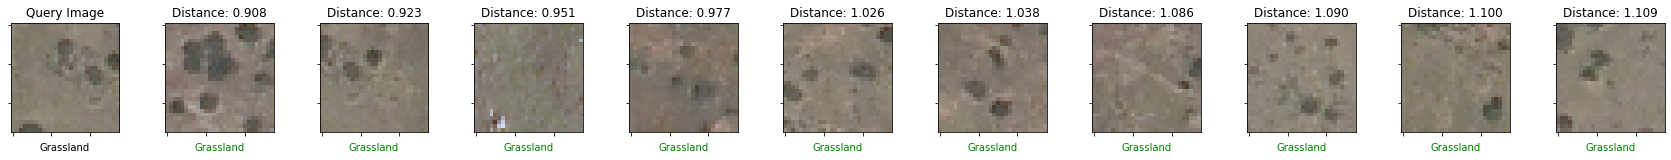

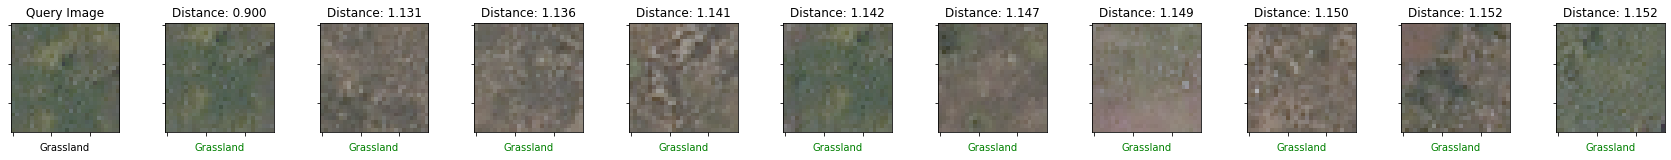

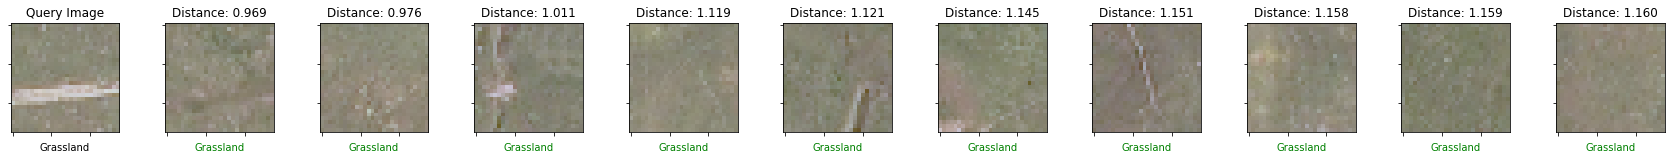

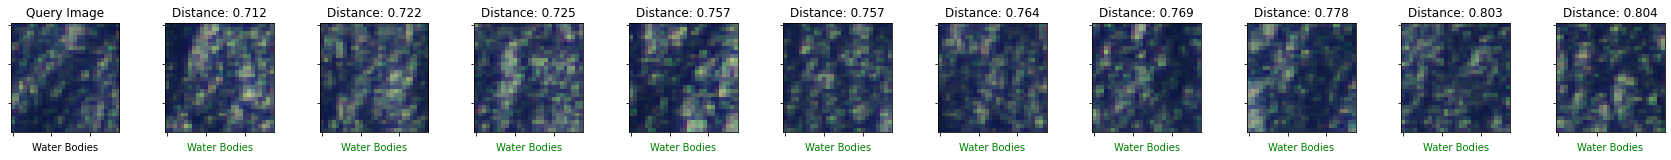

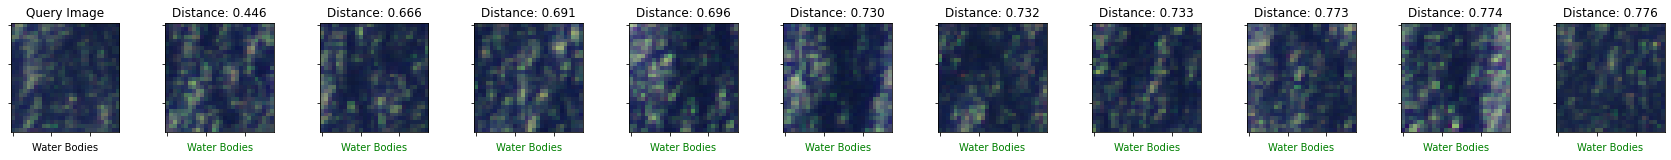

In [31]:
query_indices = np.random.choice(len(x_train), 5, replace=False)
for index in query_indices:
    top_k_pred(x_train, y_train, train_similarities, index, 10)

Let's do the same thing for our validation set.

In [32]:
val_embeddings = prediction_model.predict(x_val)
val_similarities = euclidean_distances(val_embeddings)
del val_embeddings

254/254 [==============================] - 2s 7ms/step


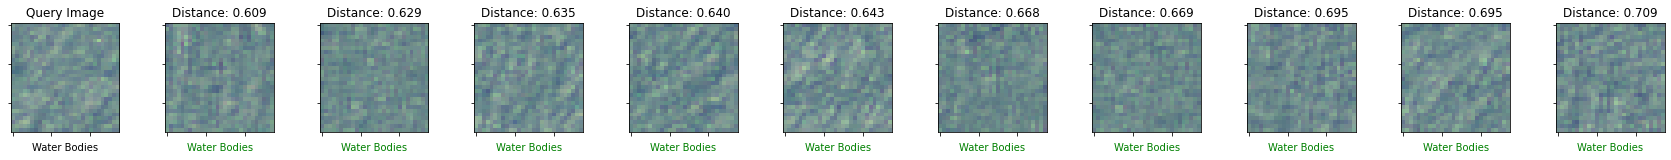

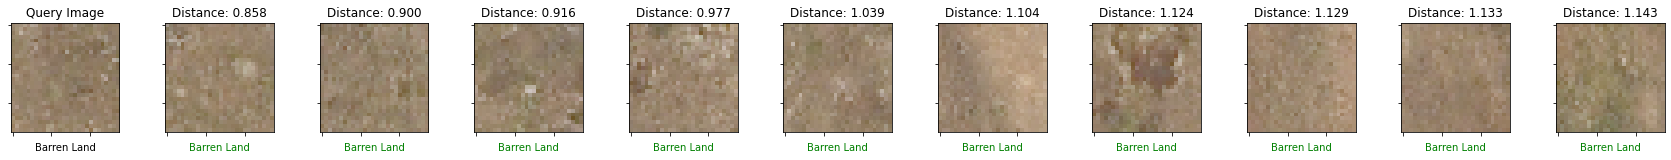

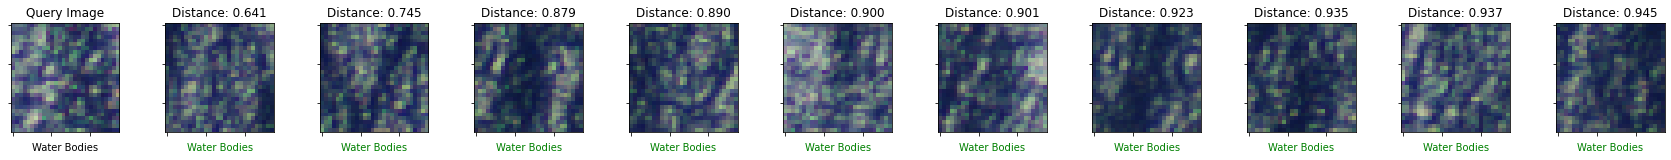

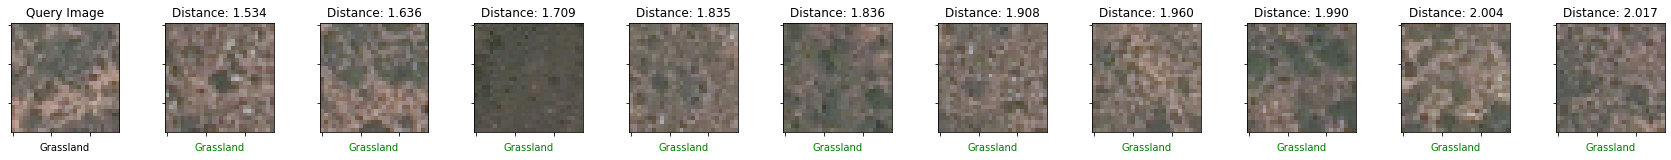

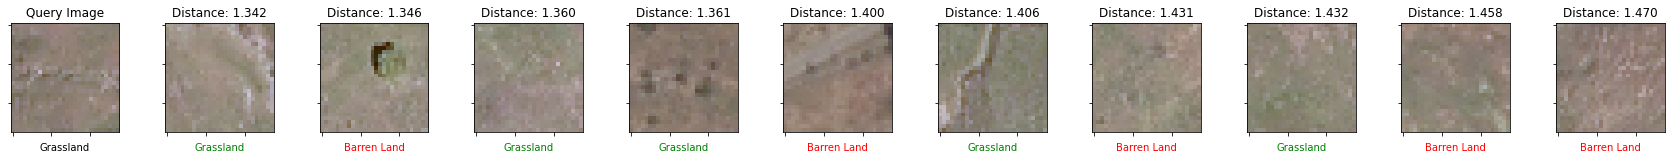

In [33]:
query_indices = np.random.choice(len(x_val), 5, replace=False)
for index in query_indices:
    top_k_pred(x_val, y_val, val_similarities, index, 10)

As can be seen, the model does pretty good on both the training set and the validation set. But let's go into the next section, where we'll inspect this result more statistically.

The following function will calculate the top-*k* accuracy score of the model on a dataset.

In [113]:
def top_k_acc_score(similarity_matrix, y, k):
    ranks = np.argsort(similarity_matrix)[:, 1:k+1]
    y_pred = y[ranks]
    y_true = np.repeat(np.expand_dims(y, -1), k, -1)
    corrects = (y_pred == y_true).any(1)
    n_corrects = corrects.sum()
    return n_corrects / len(y) * 100

Here's how the model performs on the validation set with *k*=3.

In [115]:
print(f'Validation Accuracy: {top_k_acc_score(val_similarities, y_val, 3):.4f}')

Validation Accuracy: 99.1605


# Acknowledgements
1. Cristian Lungu's <a href="https://youtu.be/50cBvizRuM0" target="_blank">Tutorial</a> about Triplet Loss on YouTube
2. DeepLearning.AI's <a href="https://youtu.be/d2XB5-tuCWU" target="_blank">Lecture</a> on Triplet Loss in the Convolutional Neural Networks Course